# Определение стоимости автомобилей

## Вступление

**Описание проекта**<br>
Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

**Цель**<br>
Построить модель, которая умеет определять стоимость клиентского автомобиля. 

В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

**Критерии**, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Основные шаги:**<br>
- Загрузить данные
- Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
- Подготовить выборки для обучения моделей.
- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
- Проанализировать время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

**Примечания:**<br>
- Для оценки качества моделей применять метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освоить библиотеку LightGBM и её средствами построить модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook получить используя специальную команду.
- Модель градиентного бустинга может долго обучаться, поэтому стоит изменить у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалить лишние переменные оператором del.

**Описание данных** 
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

## Чтение и изучение данных

In [81]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor



In [82]:
# открываем и чекаем исходный датасет
try:
    df = pd.read_csv('autos.csv')
except FileNotFoundError:
    df = pd.read_csv('/datasets/autos.csv')

In [83]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Док читается корректно

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

На вид - у всех данных в полне корректный тип данных. Кроме признаков с датой.

In [85]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуски есть только у 5 признаков - кузов, КПП, модель, топливо, ремонт

In [86]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


На вскидку сразу видим, что есть аномалии у признаков: год регистрации, мощность, у почтового индекса возможно и колво фото максимально странное

## Изучение, предобработка, ИАД

### Изучим даты

In [87]:
# День недели, месяц и год выгрузки базы
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M')

Преобразовать преобразовали, но есть подозрение, что это ненужные данные для построения модели

Предположу, что "дата последней активности пользователя" нам не нужна будет. По моей логике от этого фактора (в нашем проекте) не должна зависеть стоимость авто. Если только не вытащить из даты создания создания анкеты - год, месяц или сезонность. И возможно в этом сможет прослеживаться зависимость цены от даты создания объявления.

In [88]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M')
df['YearCreated'] = df['DateCreated'].dt.year
df['MonthCreated'] = df['DateCreated'].dt.month
df['WeekdayCreated'] = df['DateCreated'].dt.weekday

In [89]:
df['YearCreated'].value_counts()

2016    354343
2015        25
2014         1
Name: YearCreated, dtype: int64

Знание года продажи - мы сможем сформирвоать информацию ввиде "возраста" авто. Этот признак оставим

In [90]:
df['MonthCreated'].value_counts()

3     296759
4      57119
2        397
1         70
11         9
12         9
9          3
8          2
6          1
Name: MonthCreated, dtype: int64

Исходя из частотного распределения по месяцам - смею предположить, что вся база у нас в основном за март-апрель, ну или сервис работает крайне недолго. В общем, я считаю, что здесь будет ложный путь "обучения модели".

In [91]:
df['WeekdayCreated'].value_counts()

0    63283
5    57031
1    51404
6    48848
2    47284
3    45549
4    40970
Name: WeekdayCreated, dtype: int64

Здесь уже видно более менее равномерное распределение, в целом думаю можно оставить эту информацию.

Удалю сразу лишние признаки

In [92]:
df = df.drop(['DateCrawled', 'DateCreated', 'MonthCreated', 'LastSeen'], axis=1)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
 11  NumberOfPictures   354369 non-null  int64 
 12  PostalCode         354369 non-null  int64 
 13  YearCreated        354369 non-null  int64 
 14  WeekdayCreated     354369 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 40.6+ MB


### Изучим категориальные данные

#### VehicleType

In [94]:
df['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

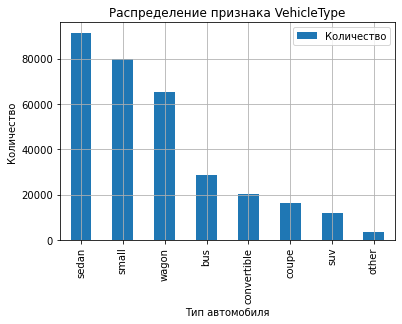

In [95]:
# df['VehicleType'].value_counts().plot(
#     kind='bar',
#     grid=True,
#     title='Распределение признака VehicleType'
# )

ax = df['VehicleType'].value_counts().plot(
    kind='bar',
    grid=True,
    title='Распределение признака VehicleType'
)

ax.set_xlabel('Тип автомобиля')
ax.set_ylabel('Количество')
ax.legend(['Количество'])

plt.show()


выглядит вполне адекватно все, но у нас тут были пропуски

In [96]:
df['VehicleType'].isna().mean() * 100

10.57936783409384

пропуски составляют почти 11% - заполнять их медианным значением, как будто бы слишком критично. Но далее посомтрим, что с этим можно будет сделать

#### Gearbox

In [97]:
df['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

Здесь в целом логично было увидеть две осовные категории. Так же помним, что были пропуски.

#### Model

In [98]:
df['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [99]:
df['Model'].value_counts().shape

(250,)

Здесь видим огромное количество различных моделей, думаю это слишком отчаянной затеей будет в ручную вычислять возможные неявные дубликаты, особенно когда не особо знаю модели машин. Плюс здесь так же были пропуски

#### FuelType

In [100]:
df['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

В целом все выглядит неплохо, но помним, что тут также были пропуски

#### Brand

In [101]:
df['Brand'].value_counts().head(10)

volkswagen       77013
opel             39931
bmw              36914
mercedes_benz    32046
audi             29456
ford             25179
renault          17927
peugeot          10998
fiat              9643
seat              6907
Name: Brand, dtype: int64

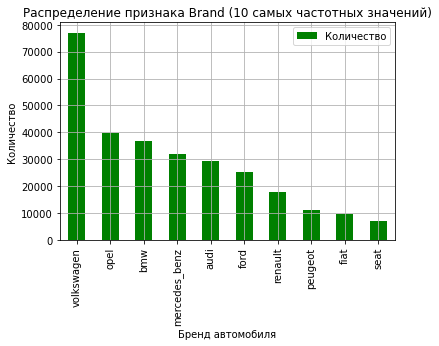

In [102]:
# df['Brand'].value_counts().head(20).plot(kind='bar', grid=True)

ax = df['Brand'].value_counts().head(10).plot(
    kind='bar',
    grid=True,
    title='Распределение признака Brand (10 самых частотных значений)',
    color='green'
)

ax.set_xlabel('Бренд автомобиля')
ax.set_ylabel('Количество')
ax.legend(['Количество'])

plt.show()

Здесь все супер, пропусков не было, данные выглядят очень хорошо и чисто. Видно какая марка пользуется дикой популярностью по сравнению с другими марками авто

#### Repaired

In [103]:
df['Repaired'].value_counts()

no     247161
yes     36054
Name: Repaired, dtype: int64

В целом тоже все выглядит хорошо, единственно то что думаю можно перевести эти значения в бинарные, где 1 - да, 0 - нет

In [104]:
# df['Repaired'] = df['Repaired'].apply(lambda x: 1 if x == 'yes' else 0)

### Изучим количественные данные

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
 11  NumberOfPictures   354369 non-null  int64 
 12  PostalCode         354369 non-null  int64 
 13  YearCreated        354369 non-null  int64 
 14  WeekdayCreated     354369 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 40.6+ MB


In [106]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,YearCreated,WeekdayCreated
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087,2015.999924,2.891737
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248,0.009046,2.075846
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,2014.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000,2016.000000,1.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000,2016.000000,3.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000,2016.000000,5.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,2016.000000,6.000000


#### Price

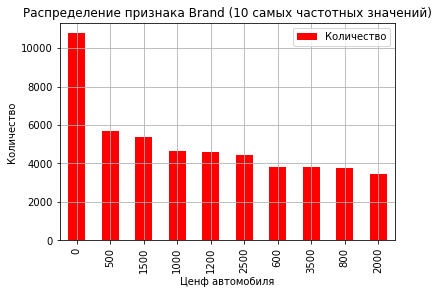

In [107]:
ax = df['Price'].value_counts().head(10).plot(
    kind='bar',
    grid=True,
    title='Распределение признака Brand (10 самых частотных значений)',
    color='red'
)

ax.set_xlabel('Ценф автомобиля')
ax.set_ylabel('Количество')
ax.legend(['Количество'])

plt.show()

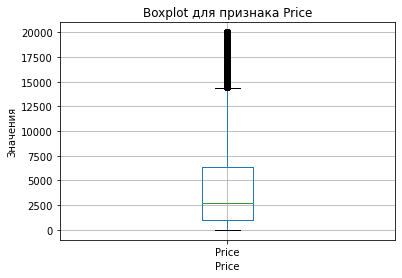

In [108]:
ax = df.boxplot(column='Price', grid=True)

# Настройка осей и заголовка
ax.set_title('Boxplot для признака Price')
ax.set_xlabel('Price')
ax.set_ylabel('Значения')

plt.show()


Да, видим, что есть выбросы, заменим их на медианное значение по ряду признаков. В зависимости от мощности и бренда авто.

In [109]:
group_median = df.groupby('Brand')['Price'].median()

Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR
up = Q3 + 1.5 * IQR

df = df.query('Price <= @up')

#### RegistrationYear

In [110]:
df['RegistrationYear'].value_counts()

2000    24429
1999    22677
2005    21685
2001    20015
2003    19590
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: RegistrationYear, Length: 149, dtype: int64

In [111]:
df[df['RegistrationYear'] > 2016]['RegistrationYear'].value_counts().shape[0] / df.shape[0] * 100

0.012224574376099466

In [112]:
df[df['RegistrationYear'] < 1970]['RegistrationYear'].value_counts().shape[0] / df.shape[0] * 100

0.018187781388830915

в целом, видим что это крайне маленькое количество значений, которые можно назвать выбросами/аномалиями, нет особых идей что можно с этим сделать. Думаю просто удалить это критично будет, а может быть заменить их все на 0. ЧТобы создать им некую "категорию".
Границы выбрал рандомно, от 1970 по текущий год. ранее 1970 года - думаю это уже прям риоритет риоритет, который люби очень дешево будет стоить, либо непристойно много

In [113]:
df = df.query('1970 < RegistrationYear < 2016')

#### Power

In [114]:
df['Power'].value_counts()

0        32484
75       21834
60       14528
150      13282
101      12296
         ...  
1312         1
1937         1
3454         1
19208        1
1241         1
Name: Power, Length: 651, dtype: int64

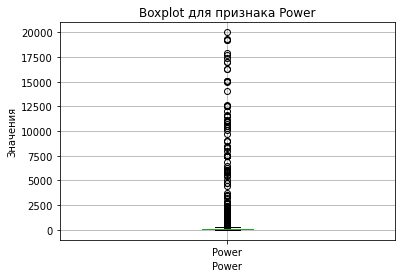

In [115]:
ax = df.boxplot(column='Power', grid=True)

# Настройка осей и заголовка
ax.set_title('Boxplot для признака Power')
ax.set_xlabel('Power')
ax.set_ylabel('Значения')

plt.show()


Тут, конечно, что-то немыслимое с количеством и "силой" выбросов-аномалий. Преобразуем аномалии так же медианным, но уже в зависимости от года и бренда авто

In [116]:
group_median2 = df.groupby(['Brand'])['Power'].median()

Q1 = df['Power'].quantile(0.25)
Q3 = df['Power'].quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR
up = Q3 + 1.5 * IQR

In [117]:
# df[df['Power'] > up].count()

In [118]:
def new_power(row):
    if row['Power'] >= up:
        row['Power'] = group_median2[row['Brand']]
    return row

df = df.apply(new_power, axis=1)

In [119]:
# df[df['Power'] > up].count()

#### Kilometer

In [120]:
df['Kilometer'].value_counts()

150000    214513
125000     32057
100000     12715
90000       9731
80000       8323
70000       6911
60000       5824
5000        5011
50000       4734
40000       3630
30000       3245
20000       2832
10000        766
Name: Kilometer, dtype: int64

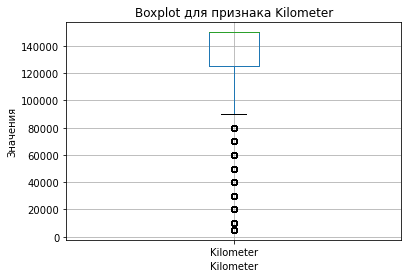

In [121]:
ax = df.boxplot(column='Kilometer', grid=True)

# Настройка осей и заголовка
ax.set_title('Boxplot для признака Kilometer')
ax.set_xlabel('Kilometer')
ax.set_ylabel('Значения')

plt.show()


В данном признаке, я сначала подумал тоже есть выбросы, но самое максимальное значение является и медианным, поэтому думаю данные вполне реальны. Здесь скорее есть наоборот критично маленькие значения. Можем заметить, что есть четки разграничения по пробегу, поэтому можно считать данный признак "категориальным"

In [122]:
df['Kilometer'] = df['Kilometer'].astype('str')

#### RegistrationMonth

In [123]:
df['RegistrationMonth'].value_counts()

3     30511
0     30088
6     27712
5     25739
4     25647
7     23951
10    23117
12    21630
11    21329
9     21089
1     20480
8     20036
2     18963
Name: RegistrationMonth, dtype: int64

<AxesSubplot:xlabel='RegistrationMonth'>

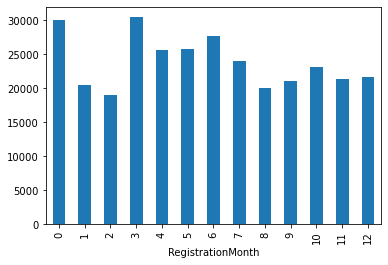

In [124]:
df.groupby('RegistrationMonth')['RegistrationMonth'].count().plot(kind='bar')

С месяцами, в целом все хорошо. Дума может что-то по типу нормального распеделния увижу)))

#### NumberOfPictures

In [125]:
df['NumberOfPictures'].unique()

array([0])

Видим, что в датасете действительно нет никаких данных по этому признаку. Значит его можно и удалить из нашего датафрейма, ввиду информативности

In [126]:
df = df.drop(['NumberOfPictures'], axis=1)

#### PostalCode

In [127]:
df['PostalCode'].value_counts()

10115    692
65428    532
66333    295
44145    285
52525    281
        ... 
26906      1
91289      1
6922       1
79599      1
95691      1
Name: PostalCode, Length: 8114, dtype: int64

Двоякие мысли. 1 - видно, что не все почтовые индексы разные, есть совпадающие, значит в данных может прослеживаться какая-то завиисмость. но 2 - не так много совпадающих значений. И тут соотвественно тоже 2 итога, либо нужно дропнуть признак, либо подумать, по какому признаку можно объяединить индексы, чтобы получить меньше категорий и при это "шире".

In [128]:
states_zipcodes = {
    "Массачусетс": [1000, 2791],
    "Род-Айленд": [2801, 2940],
    "Нью-Гэмпшир": [3031, 3904],
    "Мэн": [3901, 4992],
    "Вермонт": [5001, 5907],
    "Коннектикут": [6001, 6927],
    "Нью-Джерси": [7001, 8989],
    "Нью-Йорк (штат)": [10000, 14999],
    "Пенсильвания": [15001, 19699],
    "Делавэр": [19701, 19980],
    "Мэриленд": [20600, 22214],
    "Виргиния": [22003, 24966],
    "Западная Виргиния": [24712, 26886],
    "Северная Каролина": [27000, 28999],
    "Южная Каролина": [29000, 29945],
    "Джорджия": [30000, 31999],
    "Флорида": [32000, 34999],
    "Алабама": [35004, 36925],
    "Теннесси": [37000, 38599],
    "Миссисипи (штат)": [38601, 39776],
    "Кентукки": [40003, 42788],
    "Огайо": [43000, 45899],
    "Индиана": [46001, 47997],
    "Мичиган": [48000, 49971],
    "Айова": [50001, 52809],
    "Висконсин": [53001, 54990],
    "Миннесота": [55001, 56763],
    "Южная Дакота": [57001, 57799],
    "Северная Дакота": [58001, 58856],
    "Монтана": [59001, 59937],
    "Иллинойс": [60001, 62999],
    "Миссури (штат)": [63005, 66160],
    "Канзас": [66002, 67954],
    "Небраска": [68001, 69367],
    "Луизиана": [70000, 71599],
    "Арканзас": [71601, 72959],
    "Оклахома": [73001, 74966],
    "Техас": [75000, 79999],
    "Колорадо": [80000, 81658],
    "Вайоминг": [82001, 83128],
    "Айдахо": [83201, 83877],
    "Юта": [84001, 84791],
    "Аризона": [85001, 86556],
    "Нью-Мексико": [87000, 88439],
    "Невада": [88900, 89883],
    "Калифорния": [90000, 96199],
    "Гавайи": [96701, 96863],
    "Орегон": [97001, 97920],
    "Вашингтон (штат)": [98000, 99403],
    "Аляска": [99501, 99950]
}
#     "Вашингтон": [20001, 20091, 20201, 20599],

In [129]:
states_zipcodes_mexico = {
    "Мехико": [1000, 16910],
    "Агуаскальентес (штат)": [20000, 20997],
    "Нижняя Калифорния": [21330, 22997],
    "Южная Нижняя Калифорния": [23000, 23999],
    "Кампече (штат)": [24000, 24936],
    "Коауила": [25000, 27997],
    "Колима (штат)": [28000, 28989],
    "Чьяпас": [29010, 30997],
    "Чиуауа (значения)": [31000, 33997],
    "Дуранго (штат)": [34000, 35987],
    "Гуанахуато (штат)": [36000, 38997],
    "Герреро": [39000, 41997],
    "Идальго (штат)": [42000, 43999],
    "Халиско": [44000, 49994],
    "Мехико (штат)": [50000, 66740],
    "Мичоакан": [58000, 61998],
    "Морелос": [62000, 62997],
    "Наярит": [63000, 63996],
    "Нуэво-Леон": [64008, 67996],
    "Оахака (штат)": [68000, 71998],
    "Пуэбла": [72000, 75997],
    "Керетаро": [76000, 76998],
    "Кинтана-Роо": [77000, 77997],
    "Сан-Луис-Потоси (штат)": [78000, 79997],
    "Синалоа": [80000, 82996],
    "Сонора": [83000, 85994],
    "Табаско": [86000, 86998],
    "Тамаулипас": [87000, 89978],
    "Тласкала (штат)": [90010, 90990],
    "Веракрус (штат)": [91010, 96998],
    "Юкатан (штат)": [97000, 97996],
    "Сакатекас (штат)": [98010, 99998]
}

In [130]:
def zip_to_state(zipcode):
    for key, value in states_zipcodes.items():
        if value[0] <= zipcode <= value[1]:
            return key
    if 20001 <= zipcode <= 20091 or 20201 <= zipcode <= 20599:
        return 'Вашингтон'
    return zipcode

In [131]:
def zip_to_state_mexico(zipcode):
    if isinstance(zipcode, int):
        for key, value in states_zipcodes_mexico.items():
            if value[0] <= zipcode <= value[1]:
                return key
    else:
        return zipcode

In [132]:
df['PostalCodeByState'] = df['PostalCode'].apply(zip_to_state)
df['PostalCodeByState'] = df['PostalCodeByState'].apply(zip_to_state_mexico)
# df['PostalCodeByState'] = df['PostalCodeByState'].apply(zip_to_state_mexico)

In [133]:
df['PostalCodeByState'].value_counts()

Калифорния               16307
Нью-Йорк (штат)          15279
Миссури (штат)           14480
Огайо                    12649
Флорида                  12569
                         ...  
Халиско                    377
Юкатан (штат)              301
Род-Айленд                 265
Агуаскальентес (штат)      170
Сонора                      56
Name: PostalCodeByState, Length: 62, dtype: int64

In [134]:
df['PostalCodeByState'].isna().sum()

15

Выбрал второй путь, все отлично получилось, каждый индекс нашел свой штат. Теперь у нас в разы меньше уникальных категориальных значений и все они довольно неплохо укомплектованы. Видим, что чаще всего машинки продают в Калифорнии и Нью-Йорка. И появилось 20 пропусков, но думаю это вообще не занчительно по сравнению с тем фактом что из 8143 значений сократили до 62.

In [135]:
df = df.drop(['PostalCode'], axis=1)

#### Определим сколько машинке лет

In [136]:
df['Age'] = df['YearCreated'] - df['RegistrationYear']

In [137]:
df['Age'].isna().sum()

0

In [138]:
df['Age'].value_counts()

16    24429
17    22677
11    21683
15    20015
13    19591
12    19363
10    19070
14    18958
18    17843
9     15879
19    14640
8     13667
7     12655
20    10807
21     9568
6      8540
5      7136
4      4893
22     4814
23     3397
24     2966
26     2768
25     2732
3      2467
2      1389
27     1294
28      920
1       789
31      725
29      647
36      568
30      519
33      400
32      384
34      301
37      261
38      249
35      245
44      166
40      162
39      161
43      146
42      144
45      139
41      125
Name: Age, dtype: int64

In [139]:
df[df['Age'] < 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,YearCreated,WeekdayCreated,PostalCodeByState,Age


Есть какието аномальные значения по типу "минуса". Даже не знаю, что с этим сделать. как будто бы просто модуль на всех накинуть - критично, значений не так уж и мало. Оставить как есть - тоже критично, как возраст может быть отрицательным? но и с другой стороны может быть наоборот модель научится определять "лжецов"

In [140]:
df = df.query('Age >= 0')

In [141]:
df = df.drop(['RegistrationYear', 'YearCreated'], axis=1)

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310292 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              310292 non-null  int64  
 1   VehicleType        297341 non-null  object 
 2   Gearbox            294463 non-null  object 
 3   Power              310292 non-null  float64
 4   Model              294989 non-null  object 
 5   Kilometer          310292 non-null  object 
 6   RegistrationMonth  310292 non-null  int64  
 7   FuelType           287616 non-null  object 
 8   Brand              310292 non-null  object 
 9   Repaired           251744 non-null  object 
 10  WeekdayCreated     310292 non-null  int64  
 11  PostalCodeByState  310277 non-null  object 
 12  Age                310292 non-null  int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 33.1+ MB


### Проверим данные на мультиколлинеарность

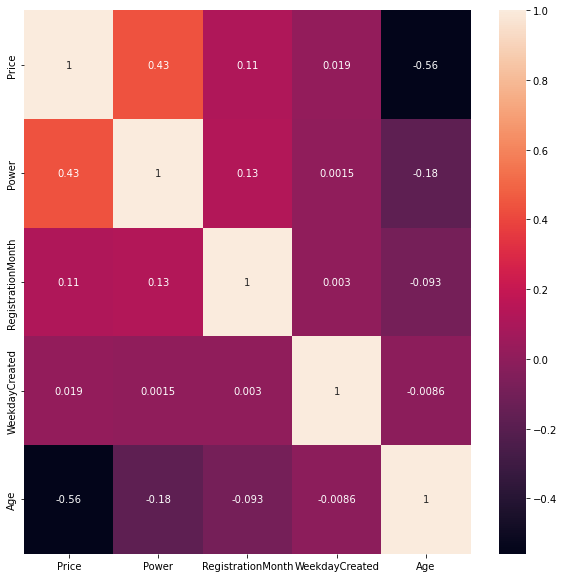

In [143]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

Здесь видим, что признаки идеальны - практически и намека нет на их мультиколлинеарность, так как все коээфиценты близки к нулю. Но признаки WeekdayCreated и RegistrationMonth практически нулевые. Поэтому можно принебречь данными признаками.

In [144]:
df = df.drop(['WeekdayCreated', 'RegistrationMonth'], axis=1)

## Подготовка к ML

In [145]:
# Разобьем на категории наши данные: категориальные, количественные и те что планируем прогнать через kmean

numerical_features = ['Power', 'Age']
categorical_features = ['VehicleType', 'Gearbox', 'Model',
                        'FuelType', 'Brand', 'Repaired',
                        'PostalCodeByState', 'Kilometer']

In [146]:
df[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310292 entries, 0 to 354368
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        297341 non-null  object
 1   Gearbox            294463 non-null  object
 2   Model              294989 non-null  object
 3   FuelType           287616 non-null  object
 4   Brand              310292 non-null  object
 5   Repaired           251744 non-null  object
 6   PostalCodeByState  310277 non-null  object
 7   Kilometer          310292 non-null  object
dtypes: object(8)
memory usage: 21.3+ MB


In [147]:
X = df.drop(['Price'], axis=1)
Y = df['Price']

# Разделим данные на тренировочную, валидационную и тестовую выборки
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.4, random_state=12345)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_valid, Y_valid, test_size=0.5, random_state=12345)

In [148]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

(186175, 10) (62058, 10) (62059, 10)
(186175,) (62058,) (62059,)


Размерность совпадает, все хорошо

In [149]:
# Определяем шаги для пайплайна
numerical_transformer = Pipeline(steps=[
        ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', TargetEncoder(handle_unknown='value'))  
])

# Объединяем обработку признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Создали пайплайны по заполнению пропусков, категоризации категориальных значений и масштабировании количественных. Выбрал TargetEncoder потому что он учитывает взаимосвязь между категориальным признаком и целевой переменной, устойчив к шуму в данных. Но так же может усилить переобучение данных. Выбрал RobustScaler - он устойчив к выбросам и аномалиям (котоыре у нас есть), масштабирует и работает с данными, даже если не нормально распределены.

### Piplines для 4 моделей: решающее дерево, случайный лес, lgb и catboost

In [150]:
models = {
    'model': [],
    'params': [],
    'RMSE': [],
    'time_train': [],
    'time_predict': [],
    'time_total': []
}

Создал словарь, в который буду сохранять все ключевые метрики, по которым будем выбирать победителя

#### Решающее дерево

In [151]:
%%time

# Создаем пайплайн с предобработкой и моделью
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])

# Словарь гиперпараметров для модели (не пайплайна)
tree_param_grid = {
    'model__max_depth': np.arange(1, 100),
    'model__min_samples_split': np.arange(2, 10),
    'model__min_samples_leaf': np.arange(1, 5)
}

# Создаем объект RandomizedSearchCV для модели с рассматриваемыми гиперпараметрами
tree_grid_search = RandomizedSearchCV(tree_pipeline, tree_param_grid, cv=5,
                                            scoring='neg_mean_squared_error', n_iter=10, random_state=12345)

start1 = time.time()
# Обучаем на лучших данных
tree_grid_search.fit(X_train, Y_train)
end1 = time.time()

# Лучшие параметры и оценки для модели
best_tree_params = tree_grid_search.best_params_
best_tree_score = tree_grid_search.best_score_
rmse_tree = np.sqrt(-best_tree_score)

print(best_tree_params)
print("RMSE на тренировочной выборке:", rmse_tree)

# Смотрим что по валидационной выборке получается
start2 = time.time()
y_pred_valid_tree = tree_grid_search.predict(X_valid)
rmse_valid_tree = np.sqrt(mean_squared_error(Y_valid, y_pred_valid_tree))
print("RMSE на валидационной выборке:", rmse_valid_tree)
end2 = time.time()


models['model'].append('Decision Tree')
models['params'].append(best_tree_params)
models['RMSE'].append(rmse_valid_tree)
models['time_train'].append(round(end1 - start1, 2))
models['time_predict'].append(round(end2 - start2, 2))
models['time_total'].append(round(end2 - start2, 2) + round(end1 - start1, 2))


{'model__min_samples_split': 8, 'model__min_samples_leaf': 4, 'model__max_depth': 12}
RMSE на тренировочной выборке: 1655.6538806081812
RMSE на валидационной выборке: 1653.9817163791683
CPU times: user 1min 21s, sys: 500 ms, total: 1min 22s
Wall time: 1min 22s


Обучили модель решающего дерева, с перебором нескольких гиперпараметров. Общее время обучения и предскзаания на валдие - 82 секунды. RMSE на валидационной выборке составило 1653

#### Случайный лес

In [152]:
%%time

forest_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor())])

forest_param_grid = {
    'model__n_estimators': np.arange(1, 10),
    'model__max_depth': np.arange(1, 10),
    'model__min_samples_split': np.arange(2, 10),
    'model__min_samples_leaf': np.arange(1, 5)
}

# Создаем объект RandomizedSearchCV для модели с рассматриваемыми гиперпараметрами
forest_grid_search = RandomizedSearchCV(forest_pipeline, forest_param_grid, cv=5,
                                            scoring='neg_mean_squared_error', n_iter=10, random_state=12345)

start1 = time.time()
# Применяем лучшие гиперпараметры для модели
forest_grid_search.fit(X_train, Y_train)
end1 = time.time()

# Лучшие параметры и оценки для модели
best_forest_params = forest_grid_search.best_params_
best_forest_score = forest_grid_search.best_score_
rmse_forest = np.sqrt(-best_forest_score)

print(best_forest_params)
print("RMSE на тренировочной выборке:", rmse_forest)

start2 = time.time()
y_pred_valid_forest = forest_grid_search.predict(X_valid)
rmse_valid_forest = np.sqrt(mean_squared_error(Y_valid, y_pred_valid_forest))
print("RMSE на валидационной выборке:", rmse_valid_forest)
end2 = time.time()

models['model'].append('Random Forest')
models['params'].append(best_forest_params)
models['RMSE'].append(rmse_valid_forest)
models['time_train'].append(round(end1 - start1, 2))
models['time_predict'].append(round(end2 - start2, 2))
models['time_total'].append(round(end2 - start2, 2) + round(end1 - start1, 2))

{'model__n_estimators': 9, 'model__min_samples_split': 3, 'model__min_samples_leaf': 3, 'model__max_depth': 8}
RMSE на тренировочной выборке: 1713.391958719413
RMSE на валидационной выборке: 1720.590346428211
CPU times: user 1min 17s, sys: 618 ms, total: 1min 18s
Wall time: 1min 19s


Обучили модель случайного леса, с перебором нескольких гиперпараметров. Общее время обучения и предскзаания на валдие - 79 секунд. RMSE на валидационной выборке составило 1720.

#### LightGBM 

In [153]:
%%time

lgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', lgb.LGBMRegressor())])

lgb_param_grid = {
    'model__n_estimators': np.arange(1, 20),
    'model__max_depth': np.arange(1, 15),
}

# Создаем объект RandomizedSearchCV для модели с рассматриваемыми гиперпараметрами
lgb_grid_search = RandomizedSearchCV(lgb_pipeline, lgb_param_grid, cv=5,
                                            scoring='neg_mean_squared_error', n_iter=15, random_state=12345)

start1 = time.time()
# Применяем лучшие гиперпараметры для модели
lgb_grid_search.fit(X_train, Y_train)
end1 = time.time()

# Лучшие параметры и оценки для модели
best_lgb_params = lgb_grid_search.best_params_
best_lgb_score = lgb_grid_search.best_score_
rmse_lgb = np.sqrt(-best_lgb_score)

print(best_lgb_score)
print("RMSE на тренировочной выборке:", rmse_lgb)

start2 = time.time()
y_pred_valid_lgb = lgb_grid_search.predict(X_valid)
rmse_valid_lgb = np.sqrt(mean_squared_error(Y_valid, y_pred_valid_lgb))
print("RMSE на валидационной выборке:", rmse_valid_lgb)
end2 = time.time()


models['model'].append('LightGBM')
models['params'].append(best_lgb_params)
models['RMSE'].append(rmse_valid_lgb)
models['time_train'].append(round(end1 - start1, 2))
models['time_predict'].append(round(end2 - start2, 2))
models['time_total'].append(round(end2 - start2, 2) + round(end1 - start1, 2))

-3241033.0310609723
RMSE на тренировочной выборке: 1800.2869302033419
RMSE на валидационной выборке: 1809.7100592775837
CPU times: user 3min 53s, sys: 34.1 s, total: 4min 27s
Wall time: 1min 39s


Обучили модель LightGBM , с перебором нескольких гиперпараметров. Общее время обучения и предскзаания на валдие - 99 секунд. RMSE на валидационной выборке составило 1810

#### CatBoost

In [154]:
# %%time
# catboost_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                     ('model', CatBoostRegressor())])

# catboost_param_grid = {
#     'model__iterations': np.arange(50, 300, 25)
# }

# # Создаем объект RandomizedSearchCV для модели с рассматриваемыми гиперпараметрами
# catboost_grid_search = RandomizedSearchCV(catboost_pipeline, catboost_param_grid, cv=5,
#                                             scoring='neg_mean_squared_error', random_state=12345)

# # Поиск лучших гиперпараметров для модели
# catboost_grid_search.fit(X_train, Y_train, verbose=50)

# # Лучшие параметры и оценки для модели
# best_catboost_params = catboost_grid_search.best_params_
# best_catboost_score = catboost_grid_search.best_score_
# rmse_catboost = np.sqrt(-best_catboost_score)

# print(best_catboost_params)
# print("RMSE на тренировочной выборке:", rmse_catboost)

# y_pred_valid_catboost = catboost_grid_search.predict(X_valid)
# rmse_valid_catboost = np.sqrt(mean_squared_error(Y_valid, y_pred_valid_catboost))
# print("RMSE на валидационной выборке:", rmse_valid_catboost)

# time_list = []
# time_list.append(time.time())
# print(time_list)

Здесь у меня не получилось "по шаблону" предыдущих моделей использовать CatBoost. Не могу придумать как это подсторить, возможно ли это вообще. Буду благодарен за подсказку

In [155]:
%%time
from sklearn.model_selection import cross_val_score
catboost_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('model', CatBoostRegressor())])

iterations_list = np.arange(50,300,50)
rmse_results = {}

for iterations in iterations_list:
    catboost_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('model', CatBoostRegressor(iterations=iterations, verbose=1))])
    rmse_scores = np.sqrt(-cross_val_score(catboost_pipeline, X_train, Y_train, 
                                           cv=5, scoring='neg_mean_squared_error'))
    rmse_results[iterations] = np.mean(rmse_scores)

optimal_iters = min(rmse_results, key=rmse_results.get)

print("Лучшее колво итераций:", optimal_iters)

# Создание пайплайна с оптимальным количеством итераций
optimal_catboost_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                            ('model', CatBoostRegressor(iterations=optimal_iters))])

start1 = time.time()
optimal_catboost_pipeline.fit(X_train, Y_train)
end1 = time.time()

start2 = time.time()
y_pred_valid_optimal = optimal_catboost_pipeline.predict(X_valid)
rmse_valid_optimal = np.sqrt(mean_squared_error(Y_valid, y_pred_valid_optimal))
end2 = time.time()

print("RMSE на валидационной выборке:", rmse_valid_optimal)

models['model'].append('CatBoost')
models['params'].append(optimal_iters)
models['RMSE'].append(rmse_valid_optimal)
models['time_train'].append(round(end1 - start1, 2))
models['time_predict'].append(round(end2 - start2, 2))
models['time_total'].append(round(end2 - start2, 2) + round(end1 - start1, 2))

Learning rate set to 0.5
0:	learn: 2547.2071351	total: 69.3ms	remaining: 3.4s
1:	learn: 2095.5059223	total: 75ms	remaining: 1.8s
2:	learn: 1907.3403137	total: 80.1ms	remaining: 1.25s
3:	learn: 1822.6486495	total: 84.9ms	remaining: 976ms
4:	learn: 1780.7424623	total: 90.4ms	remaining: 814ms
5:	learn: 1753.2117328	total: 96.4ms	remaining: 707ms
6:	learn: 1735.0862491	total: 101ms	remaining: 623ms
7:	learn: 1723.7479976	total: 107ms	remaining: 562ms
8:	learn: 1707.1390071	total: 114ms	remaining: 520ms
9:	learn: 1693.0658068	total: 120ms	remaining: 481ms
10:	learn: 1680.7009715	total: 126ms	remaining: 448ms
11:	learn: 1669.8038834	total: 133ms	remaining: 420ms
12:	learn: 1658.4880147	total: 139ms	remaining: 395ms
13:	learn: 1653.9273930	total: 145ms	remaining: 372ms
14:	learn: 1644.0517047	total: 151ms	remaining: 352ms
15:	learn: 1638.2258139	total: 157ms	remaining: 334ms
16:	learn: 1631.0297047	total: 163ms	remaining: 316ms
17:	learn: 1624.0088676	total: 169ms	remaining: 301ms
18:	learn: 

"В ручную" перебрали один из основных гипперпараметров - колво итераций. Общее время обучения и предскзаания на валдие - 58 секунд. RMSE на валидационной выборке составило 1500

In [156]:
models

{'model': ['Decision Tree', 'Random Forest', 'LightGBM', 'CatBoost'],
 'params': [{'model__min_samples_split': 8,
   'model__min_samples_leaf': 4,
   'model__max_depth': 12},
  {'model__n_estimators': 9,
   'model__min_samples_split': 3,
   'model__min_samples_leaf': 3,
   'model__max_depth': 8},
  {'model__n_estimators': 18, 'model__max_depth': 8},
  250],
 'RMSE': [1653.9817163791683,
  1720.590346428211,
  1809.7100592775837,
  1499.789319444724],
 'time_train': [82.45, 79.32, 99.52, 3.28],
 'time_predict': [0.12, 0.16, 0.14, 0.13],
 'time_total': [82.57000000000001,
  79.47999999999999,
  99.66,
  3.4099999999999997]}

In [157]:
# СТроим датафрейм для наглядности
models_df = pd.DataFrame(models)
columns_ = ['model', 'RMSE', 'time_train', 'time_predict', 'time_total']
models_df = models_df[columns_]
print(models_df.transpose())

                          0              1            2            3
model         Decision Tree  Random Forest     LightGBM     CatBoost
RMSE            1653.981716    1720.590346  1809.710059  1499.789319
time_train            82.45          79.32        99.52         3.28
time_predict           0.12           0.16         0.14         0.13
time_total            82.57          79.48        99.66         3.41


По получившейс табоице, видим, что: 
- по метрике RMSE выигрывает (существенно выигрывает) модель **CatBoost**
- по времени обучения выигрывает модель **CatBoost**
- по времени предсказания выигрывает модель **Decision Tree**
- по общему времени выигрывает модель **CatBoost**

Принимаю решение - выбрать модель CatBoost для вычисления метрики по тестовой выборке. Так как по RMSE показал себя намного лучше чем все остальные, хоть и оказался медленее на 2,5 чем LightGBM. Да и по скорости обучения и общему времени всех уделал

In [158]:
start = time.time()
y_pred_CatBoost_test = optimal_catboost_pipeline.predict(X_test)
rmse_CatBoost_test = np.sqrt(mean_squared_error(Y_test, y_pred_CatBoost_test))
end = time.time()

print("RMSE на тестовой выборке на CatBoost:", rmse_CatBoost_test)
print(round(end - start, 2))

RMSE на тестовой выборке на CatBoost: 1482.1315058021546
0.16


## Вывод

- Загрузили и изучили данные. 
- Удалили нерелевантные признаки, но перед этим вытащили из них необходиму информацию (создали новые признаки).
- Раскатегорировали признак с почтовым индексом.
- Создали синтетический признак в виде возраста авто на момент публикации объявления.
- Проверили признаки на мультиколлинераность
- Разделили дф на выборки, создали пайплайны по заполнению пропусков (медианой и частотным значением), масштабирвоание (чтобы покрыть момент с аномалиями)
- Обучили 4 разные модели: решающее дерево, случайный лес, LightGBM и CatBoost. Нашли для каждой модели оптимальные гиперпарамтеры, при которых метрика RMSE на них минимальна.
- Предсказали значения для каждой модели на валидационной выборке, вычислили и записали RMSE соответствующие
- Замерили для каждой модели, время обучения и время предсказания
- По полученным данным выбрали модель CatBoost, так как обладала наимнеьшим значением RMSE и временем обучения.
- Предскзаали значения на тествоой выборке - получили значение RMSE = 1482. Время предсказания 0.16с.
- По ТЗ заказчика прошли. МОжно считать, что успех.
